# Exercise 4
## 2. Lunar Lander

The objective of these tasks are to implement two different algorithms and compare them to three environments:
* Cart Pole
* **Lunar Lander**
* Mountain Car
<br>

### <b>Group 3:</b> Cesar Laura, Ecker Annina, Dilly Julian
<div class="alert alert-block alert-info">
Note: Each of us worked on all tasks independently. We later discussed our findings and merged the best/most representative parts with eachother in one Notebook.
</div>

<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

import moviepy
from moviepy import VideoFileClip

from PIL import Image
import os
from IPython.display import Image as IPImage, display, Video, Image

from __future__ import annotations

import collections
from collections import defaultdict

import statistics

import tensorflow as tf
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

from tqdm import tqdm
from tqdm import trange

from time import time

import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from torchvision import transforms
from torchviz import make_dot, make_dot_from_trace
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

import gc

<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [2]:
gc.collect()
torch.mps.empty_cache()  # For M1/MPS

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
env = gym.make("LunarLander-v3", 
               render_mode="human", 
               continuous=False, 
               gravity=-10.0,
              enable_wind=False, 
               wind_power=15.0, 
               turbulence_power=1.5
              )

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


In [4]:
learning_rate = 0.0005 
gamma = 0.99              
epsilon_start = 1.0        
epsilon_end = 0.05        
epsilon_decay = 1500   
batch_size = 64
buffer_capacity = 10000
num_episodes = 1000
reward_threshold = 200


In [5]:
# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


# --- Q-Network ---
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# --- DQN Agent ---
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.0005, gamma=0.99):
        self.q_network = QNetwork(state_dim, action_dim)
        self.target_network = QNetwork(state_dim, action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.buffer = ReplayBuffer(10000)
        self.loss_fn = nn.SmoothL1Loss()

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.q_network.fc3.out_features)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        target = rewards + self.gamma * next_q_values * (1 - dones)
        loss = self.loss_fn(q_values, target.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


# --- Training---
def train_dqn(agent, env, num_episodes=1000, batch_size=64, epsilon_start=1.0, epsilon_end=0.05,
              epsilon_decay=1500, reward_threshold=200, min_episodes_criterion=100):

    epsilon = epsilon_start
    episode_rewards = []
    episodes_reward_window = collections.deque(maxlen=min_episodes_criterion)
    running_reward = 0
    best_reward = -float('inf')
    best_model_state = None

    start_time = time()

    with trange(num_episodes, desc="Training", unit="ep") as t:
        for episode in t:
            state, _ = env.reset()
            total_reward = 0
            done = False

            while not done:
                action = agent.select_action(state, epsilon)
                next_state, reward, done, truncated, _ = env.step(action)
                agent.buffer.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                agent.train(batch_size)

            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)

            if episode % 10 == 0:
                agent.target_network.load_state_dict(agent.q_network.state_dict())

            episode_rewards.append(total_reward)
            episodes_reward_window.append(total_reward)
            running_reward = statistics.mean(episodes_reward_window)

            if total_reward > best_reward:
                best_reward = total_reward
                best_model_state = agent.q_network.state_dict()

            t.set_postfix(episode_reward=total_reward, running_avg=running_reward, epsilon=epsilon)

            if running_reward >= reward_threshold and episode >= min_episodes_criterion:
                print(f"\nSolved at episode {episode}: running reward {running_reward:.2f}!")
                break

    end_time = time()
    elapsed = end_time - start_time
    print(f"Training completed in {elapsed:.2f} seconds.")

    if best_model_state is not None:
        torch.save(best_model_state, 'best_dqn_lunarlander.pth')

    return episode_rewards


In [ ]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

episode_rewards = train_dqn(agent, env)


In [25]:
Video('lunar_lander_annina.mov', width=500, height=500) 

In [6]:
def render_episode_gif(env, agent, max_steps=1000, filename="lunar_lander.gif"):
    state, _ = env.reset()
    images = []
    img = env.render()
    images.append(PILImage.fromarray(img))

    for step in range(1, max_steps+1):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = agent.q_network(state_tensor)
            action = q_values.argmax().item()

        state, reward, done, truncated, _ = env.step(action)

        if step % 10 == 0 or done:
            img = env.render()
            images.append(PILImage.fromarray(img))

        if done:
            break

    images[0].save(filename, save_all=True, append_images=images[1:], loop=0, duration=50)
    return filename
    

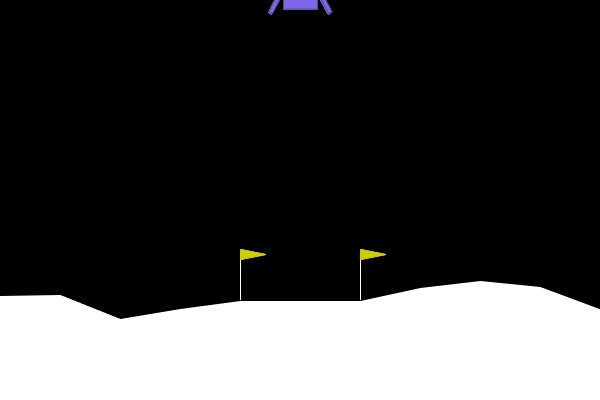

In [7]:
filename = 'lunar_lander.gif'
display(Image(filename=filename))


# Plots and Visualisations

<br>

In [8]:
def plot_rewards(episode_rewards, window=20):
    sns.set(style="darkgrid")
    smoothed = pd.Series(episode_rewards).rolling(window).mean()

    plt.figure(figsize=(10,5))
    sns.lineplot(x=range(len(episode_rewards)), y=episode_rewards, label="Reward", linewidth=1, color='MidnightBlue')
    sns.lineplot(x=range(len(smoothed)), y=smoothed, label="Smoothed", linewidth=2, color='Coral')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress - Lunar Lander")
    plt.legend()
    plt.tight_layout()
    plt.show()

episode_rewards = np.load("episode_rewards.npy")


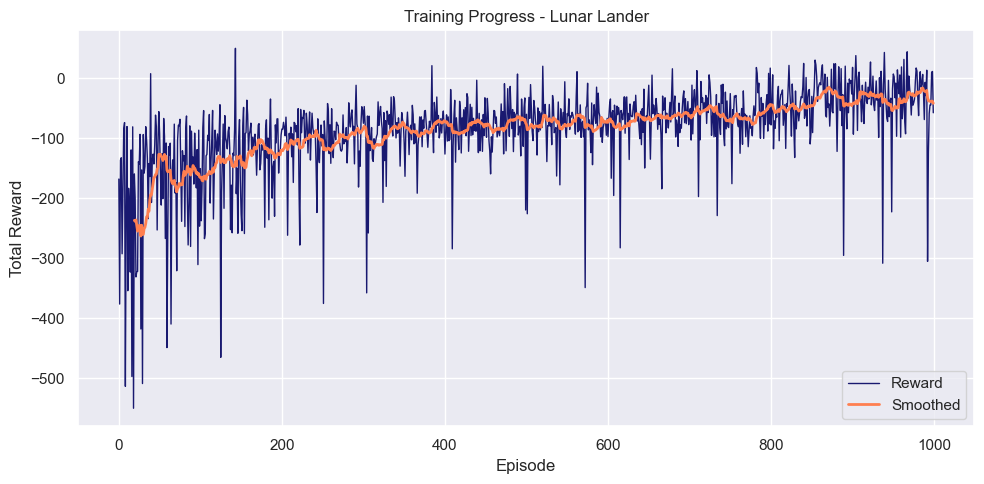

In [9]:
plot_rewards(episode_rewards)
env = gym.make("LunarLander-v3", render_mode="rgb_array")


<br>

## Evaluation of Training Progress – Lunar Lander with DQN

The plotted training rewards show that the DQN agent gradually improved its performance over time. In the early episodes, the total rewards are highly volatile, often dropping below **-400**, reflecting unstable and uncoordinated landing attempts. However, as training continues, there is a noticeable upward trend in both the raw and smoothed rewards.<br>

The *smoothed reward curve*, calculated over a rolling window, shows consistent improvement, with the agent achieving average rewards closer to **-100** in later episodes. While the agent has not consistently reached the success threshold of **200**, the performance gain demonstrates that learning is occurring.<br>

The fluctuations in raw rewards, even in later stages, are expected in a complex environment like Lunar Lander, where small changes in policy can result in significant outcome differences. Further training or hyperparameter tuning could help the agent stabilize its performance.<br>

For now we can conclude that this is a promising result, showing meaningful progress of the agent in mastering the Lunar Lander environment.

<br>

<br>

<hr>

<br>

In [12]:
agent.q_network.load_state_dict(torch.load('best_dqn_lunarlander.pth', map_location=torch.device('cpu')))
agent.q_network.eval

<bound method Module.eval of QNetwork(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)>

In [13]:
summary(agent.q_network, input_size=(8,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,152
            Linear-2                  [-1, 256]          33,024
            Linear-3                    [-1, 4]           1,028
Total params: 35,204
Trainable params: 35,204
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


<br>

<hr>

<br>

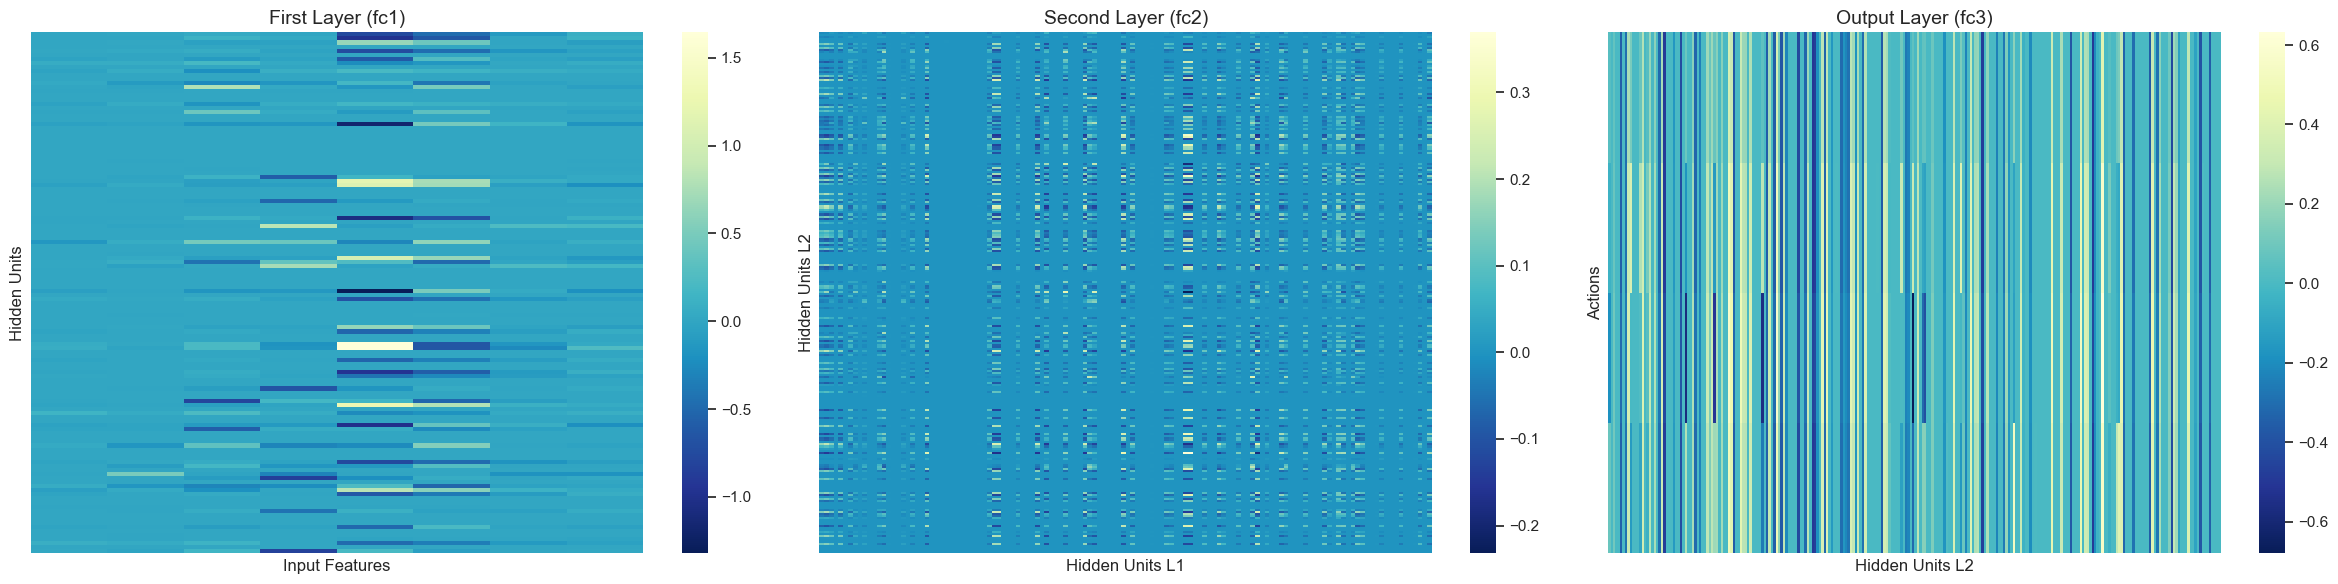

In [14]:
weights_fc1 = agent.q_network.fc1.weight.data.cpu().numpy()
weights_fc2 = agent.q_network.fc2.weight.data.cpu().numpy()
weights_fc3 = agent.q_network.fc3.weight.data.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
cmap = "YlGnBu_r"


sns.heatmap(weights_fc1, cmap=cmap, cbar=True, ax=axes[0],
            xticklabels=False, yticklabels=False)
axes[0].set_title("First Layer (fc1)", fontsize=14)
axes[0].set_xlabel("Input Features")
axes[0].set_ylabel("Hidden Units")


sns.heatmap(weights_fc2, cmap=cmap, cbar=True, ax=axes[1],
            xticklabels=False, yticklabels=False)
axes[1].set_title("Second Layer (fc2)", fontsize=14)
axes[1].set_xlabel("Hidden Units L1")
axes[1].set_ylabel("Hidden Units L2")


sns.heatmap(weights_fc3, cmap=cmap, cbar=True, ax=axes[2],
            xticklabels=False, yticklabels=False)
axes[2].set_title("Output Layer (fc3)", fontsize=14)
axes[2].set_xlabel("Hidden Units L2")
axes[2].set_ylabel("Actions")

plt.tight_layout()
plt.show()


<br>

## Interpretation

Fc1 demonstrates strong feature-specific weighting, especially for certain inputs. <br>
<br>
Fc2 reflects refined transformations with subtle variations across neurons. 
<br>
In fc3, the weights are clearly differentiated per action, indicating the network has effectively mapped processed features to distinct output decisions.
<br><br>
Through this layer-wise heatmaps we can observer how the network evolves and transform raw input into actionable insights.
<br>

<hr>

<br>

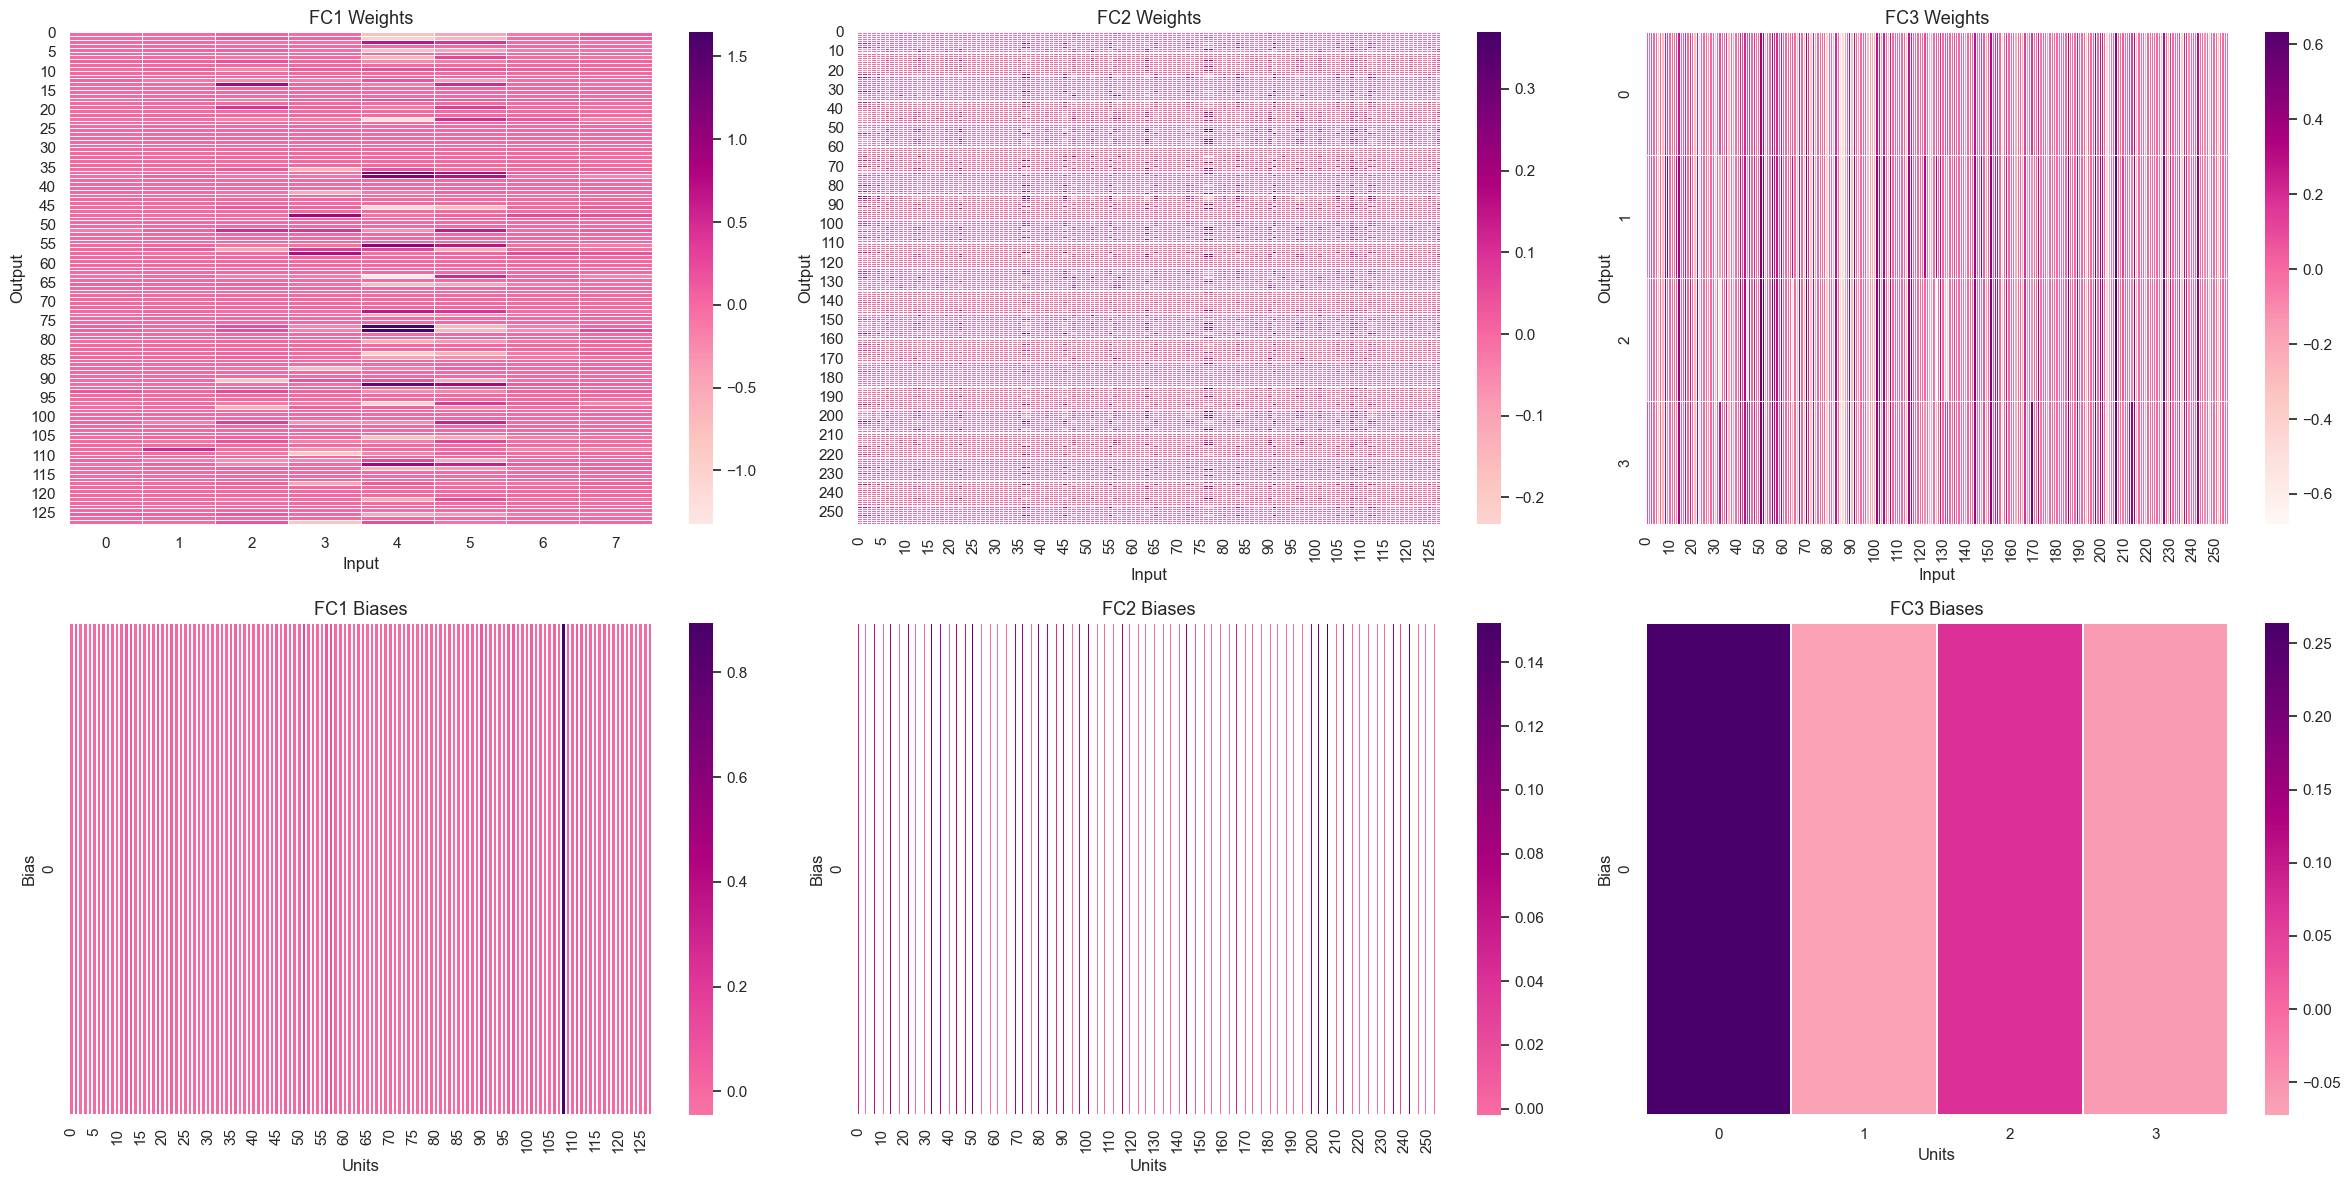

In [15]:
layers = [
    ("fc1", agent.q_network.fc1),
    ("fc2", agent.q_network.fc2),
    ("fc3", agent.q_network.fc3)
]

fig, axs = plt.subplots(2, 3, figsize=(24, 12))

for i, (name, layer) in enumerate(layers):
    weights = layer.weight.data.cpu().numpy()
    sns.heatmap(weights, ax=axs[0, i], cmap="RdPu", cbar=True, center=0, linewidths=0.4, linecolor='white')
    axs[0, i].set_title(f"{name.upper()} Weights", fontsize=13)
    axs[0, i].set_xlabel("Input")
    axs[0, i].set_ylabel("Output")

    biases = layer.bias.data.cpu().numpy().reshape(1, -1)
    sns.heatmap(biases, ax=axs[1, i], cmap="RdPu", cbar=True, center=0, linewidths=0.1, linecolor='white')
    axs[1, i].set_title(f"{name.upper()} Biases", fontsize=13)
    axs[1, i].set_xlabel("Units")
    axs[1, i].set_ylabel("Bias")

plt.tight_layout()
plt.show()

<br>

## Interpretation

The weight heatmaps reveal distinct patterns across all layers.
<br>In fc1, weights vary significantly across inputs, suggesting that the network is extracting meaningful features early on. 
<br>Fc2 shows dense, nuanced weight distributions, indicating active transformation of these features. 
<br>Fc3 weights are more focused, showing structured differentiation across actions. <br>

Bias heatmaps across all layers are consistent and evenly distributed, helping stabilize the learning process and output scaling.
<br>

<hr>

<br>

In [16]:
dummy_input = torch.zeros(1, 8)
output = agent.q_network(dummy_input)
make_dot(output, params=dict(agent.q_network.named_parameters())).render("lunar_lander_model", format="png")

'lunar_lander_model.png'

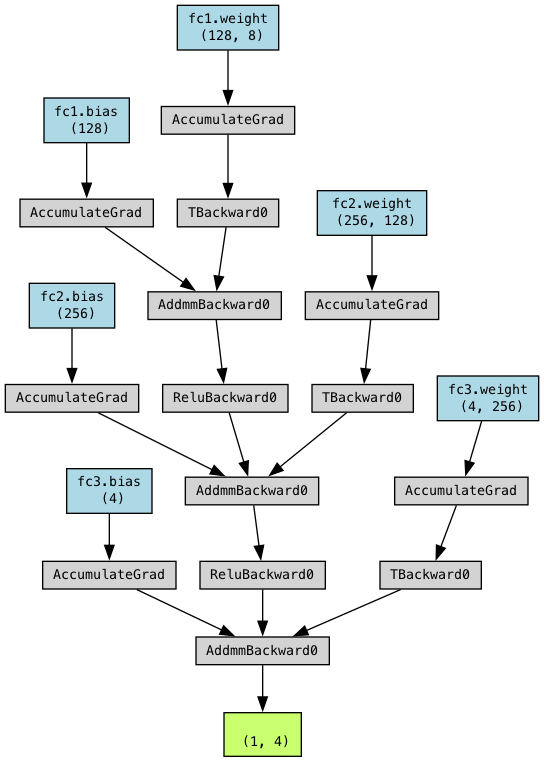

In [17]:
Image("lunar_lander_model.png")

## Flow of data and gradients through the Network

In this graphical illustration we can see the data and gradient flow through the agent’s network. Inputs pass through three fully connected layers: fc1 (8 → 128), fc2 (128 → 128), and fc3 (128 → 4).<br>
All weights and biases are actively involved, and gradient accumulation is clearly shown at each step.<br>
This indicates that the entire network contributes to both forward inference and backward optimization without unused parameters or bottlenecks.


<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

# Sources:

* [Gymnasium Farama - Basic Usage](https://gymnasium.farama.org/introduction/basic_usage/)
* [Hugging Face - Hands-On Deep-RL-Course](https://huggingface.co/learn/deep-rl-course/unit1/hands-on)
* [Finding Theta - Solving Gymnasiums Lunar Lander](https://www.findingtheta.com/blog/solving-gymnasiums-lunar-lander-with-deep-q-learning-dqn)